# Проект по созданию гибридной нейронной сети для предсказания оценки сайта.

Используемый психологический тест: тест Айзенка

Гипотезы: между данным есть корреляция, и нейросеть можно обучить на полученных данных.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
from pathlib import Path
import os
import shutil

import matplotlib.pyplot as plt

!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback
import gdown
from keras.callbacks import CSVLogger

!pip install tensorflow_addons
import tensorflow_addons as tfa

In [ ]:
cd drive/MyDrive/CRIAPP/CRIApp

# Работа с данными по псих тесту

In [ ]:
# _URL = <Демонстрационная работа> 
output = 'data.csv'
gdown.download(_URL, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1FYvj7Lk6tkfm-GC4SWPNwbfc8A25fT6n&export=download
To: /content/drive/My Drive/CRIApp/CRIApp/data.csv
100%|██████████| 4.51k/4.51k [00:00<00:00, 1.20MB/s]


'data.csv'

In [ ]:
df = pd.read_csv(output)
df = df[df.columns[2:]] # избавляемся от ненужных столбцов
print(df.shape)
df.head(3)

(16, 109)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,website №1,website №2,website №3,website №4,website №5,website №6,website №7,website №8
0,1,1,1,0,0,0,0,0,0,1,1,1,0,1,1,1,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,...,1,1,0,0,1,0,1,0,1,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0,1,1,1,1,4,1,6,5,1,1,6,4
1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,1,1,...,1,0,1,1,0,0,1,1,1,1,1,1,0,1,1,0,1,1,0,0,0,1,1,0,0,1,1,0,1,1,1,1,8,3,7,4,2,2,3,4
2,1,1,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,...,0,1,1,1,0,1,0,1,1,1,1,0,1,1,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,1,0,0,5,4,6,6,3,3,3,7


In [ ]:
y = df.iloc[:, -8:]

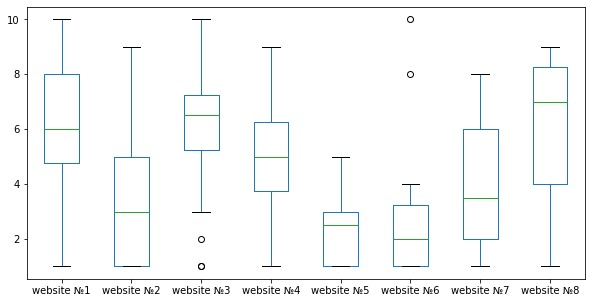

In [ ]:
y.boxplot(grid=False, figsize=(10,5)) # проверяем выбросы по сайтам
plt.show()

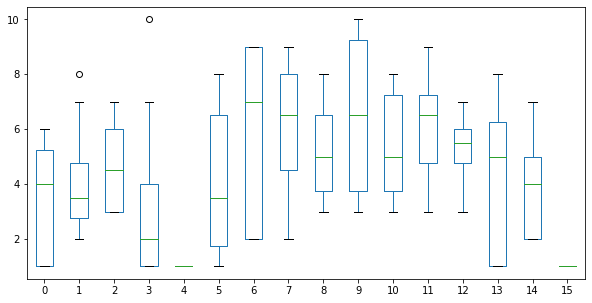

In [ ]:
y.T.boxplot(grid=False, figsize=(10,5)) # проверяем выбросы по респондентам
plt.show()

In [ ]:
# заполняем их None чтобы потом заменить на медиану
df.iloc[4, -8:] = None
df.iloc[15, -8:] = None
df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,website №1,website №2,website №3,website №4,website №5,website №6,website №7,website №8
0,1,1,1,0,0,0,0,0,0,1,1,1,0,1,1,1,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,...,1,1,0,0,1,0,1,0,1,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0,1,1,1,1,4.0,1.0,6.0,5.0,1.0,1.0,6.0,4.0
1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,1,1,...,1,0,1,1,0,0,1,1,1,1,1,1,0,1,1,0,1,1,0,0,0,1,1,0,0,1,1,0,1,1,1,1,8.0,3.0,7.0,4.0,2.0,2.0,3.0,4.0
2,1,1,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,...,0,1,1,1,0,1,0,1,1,1,1,0,1,1,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,1,0,0,5.0,4.0,6.0,6.0,3.0,3.0,3.0,7.0
3,1,0,1,0,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,0,0,0,1,1,1,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,...,1,1,0,0,0,1,1,1,0,0,1,1,1,1,0,0,1,0,0,0,1,1,1,0,1,1,1,0,1,0,1,0,7.0,2.0,10.0,3.0,1.0,1.0,1.0,2.0
4,1,0,1,1,1,1,1,1,0,1,1,1,0,0,1,1,0,1,1,1,0,0,1,1,1,1,0,1,1,1,0,1,1,1,0,0,0,0,0,1,...,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,0,1,1,1,1,1,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,1,1,1,0,1,0,1,1,0,1,1,1,0,1,1,1,0,0,1,0,1,0,1,1,0,1,1,1,1,0,1,0,0,1,1,1,0,1,1,...,1,0,1,0,0,1,1,1,0,1,1,0,1,1,1,0,0,0,0,1,0,1,0,0,1,1,1,0,1,0,0,1,8.0,1.0,2.0,3.0,1.0,4.0,6.0,8.0
6,1,1,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,1,...,1,0,0,1,0,1,0,0,1,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,1,1,1,1,0,5.0,9.0,9.0,9.0,2.0,2.0,2.0,9.0
7,0,1,0,0,0,1,1,0,0,1,1,1,0,0,1,1,0,1,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,1,0,1,1,0,1,0,...,1,0,1,1,1,0,1,0,1,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,8.0,5.0,8.0,7.0,3.0,2.0,6.0,9.0
8,1,1,1,0,1,1,1,1,1,0,1,1,1,0,1,1,1,1,0,1,0,0,1,1,1,0,0,1,1,0,0,1,0,0,0,1,0,0,1,1,...,1,0,1,1,1,0,1,0,1,1,1,0,1,1,1,0,0,1,0,0,0,1,0,0,1,1,1,0,1,1,1,0,8.0,4.0,6.0,5.0,3.0,3.0,5.0,8.0
9,0,1,0,0,1,1,1,1,1,1,0,1,1,0,1,0,0,1,0,1,1,0,1,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,...,0,1,0,0,0,0,1,1,1,0,1,0,1,1,1,0,0,1,1,0,1,1,1,1,1,1,1,0,1,0,1,1,10.0,3.0,3.0,4.0,5.0,10.0,8.0,9.0


In [ ]:
m = np.ceil(df.iloc[:, -8:].median(axis=0))

df.iloc[4, -8:] = m
df.iloc[15, -8:] = m
df.iloc[[4, 15], -8:]

,website №1,website №2,website №3,website №4,website №5,website №6,website №7,website №8
4,7.0,4.0,7.0,5.0,3.0,3.0,5.0,7.0
15,7.0,4.0,7.0,5.0,3.0,3.0,5.0,7.0


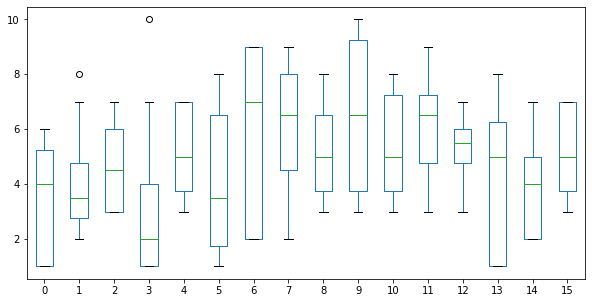

In [ ]:
y = df.iloc[:, -8:]
y.T.boxplot(grid=False, figsize=(10,5))
plt.show()

In [ ]:
# Приводим данные в построчный формат
df = pd.melt(df, 
             id_vars=df.columns.tolist()[:101],
             value_vars=[f'website №{x}' for x in range(1,9)],
             var_name='page',
             value_name='rating')
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,page,rating
0,1,1,1,0,0,0,0,0,0,1,1,1,0,1,1,1,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,...,1,1,0,1,1,0,1,1,0,0,1,0,1,0,1,1,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0,1,1,1,1,website №1,4.0
1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,1,1,...,1,1,1,1,0,1,1,0,1,1,0,0,1,1,1,1,1,1,0,1,1,0,1,1,0,0,0,1,1,0,0,1,1,0,1,1,1,1,website №1,8.0
2,1,1,0,0,0,0,1,0,1,0,0,1,1,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,...,0,1,0,0,0,1,0,1,1,1,0,1,0,1,1,1,1,0,1,1,0,0,1,1,0,1,0,1,0,0,1,1,0,0,1,1,0,0,website №1,5.0
3,1,0,1,0,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,0,0,0,1,1,1,1,0,1,0,0,1,1,0,1,0,1,0,0,0,0,...,1,1,1,1,0,1,1,1,0,0,0,1,1,1,0,0,1,1,1,1,0,0,1,0,0,0,1,1,1,0,1,1,1,0,1,0,1,0,website №1,7.0
4,1,0,1,1,1,1,1,1,0,1,1,1,0,0,1,1,0,1,1,1,0,0,1,1,1,1,0,1,1,1,0,1,1,1,0,0,0,0,0,1,...,1,1,1,1,0,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,0,1,1,1,1,1,1,1,0,website №1,7.0


In [ ]:
# очищаем столбец page
df['page'] = df['page'].apply(lambda x: int(x[-1]))
df = df.astype(np.dtype('float32'))
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,page,rating
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0
1,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,8.0
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,5.0
3,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,7.0
4,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,7.0


# Работа со скриншотами

In [ ]:
path = Path("screenshots")
path.mkdir(exist_ok=True)

In [ ]:
# картинки из открытого источника: https://www.kaggle.com/aydosphd/webscreenshots
_URL = 'https://drive.google.com/uc?id=1AAjgCsAva875_hhOoK_4k4WOl0tAjH2a&export=download'

output = 'screenshots/screenshots-224x224.7z'
gdown.download(_URL, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1AAjgCsAva875_hhOoK_4k4WOl0tAjH2a&export=download
To: /content/screenshots/screenshots-224x224.7z
400MB [00:02, 172MB/s]


'screenshots/screenshots-224x224.7z'

In [ ]:
!7z x -oscreenshots -r screenshots/screenshots-224x224.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 399615916 bytes (382 MiB)

Extracting archive: screenshots/screenshots-224x224.7z
--
Path = screenshots/screenshots-224x224.7z
Type = 7z
Physical Size = 399615916
Headers Size = 350057
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% 5        1% 207 - screenshots-224x224/machinery/scomac.com.jpg                                                         2% 421 - screenshots-224x224/machinery/www.airometrix.com.jpg                                                               

In [ ]:
!ls screenshots/screenshots-224x224/machinery | head -8

1k62.com.jpg
abe-kamery.pl.jpg
acvrn.ru.jpg
advantageequipment.net.jpg
agro-kowalski.com.pl.jpg
airtrack.ru.jpg
akku-system.hu.jpg
alfamash.ru.jpg


In [ ]:
NAMES = ["1k62.com.jpg",
         "abe-kamery.pl.jpg",
         "acvrn.ru.jpg",
         "advantageequipment.net.jpg",
         "agro-kowalski.com.pl.jpg",
         "airtrack.ru.jpg",
         "akku-system.hu.jpg",
         "alfamash.ru.jpg"]

path = "screenshots/screenshots-224x224/machinery"

folder = os.listdir(path)

images_folder = Path("images_folder")
images_folder.mkdir(exist_ok=True)

for f in folder:
  if f in NAMES:
    shutil.copy(f"{path}/{f}", images_folder)

In [ ]:
shutil.rmtree('screenshots')

In [ ]:
!ls images_folder | head 

1k62.com.jpg
abe-kamery.pl.jpg
acvrn.ru.jpg
advantageequipment.net.jpg
agro-kowalski.com.pl.jpg
airtrack.ru.jpg
akku-system.hu.jpg
alfamash.ru.jpg


In [ ]:
# проверка отсортированной папки на существования
if os.path.isdir("images_folder_sorted") and Path("images_folder_sorted").is_dir():
  shutil.rmtree("images_folder_sorted")

images_folder_sorted = Path("images_folder_sorted")
images_folder_sorted.mkdir(exist_ok=True)

c = 0 # счетчик для картинок. Нужен, чтобы не запутаться в картиках 

for r in df['rating'].unique():
  if c == len(NAMES):
    break
  p = Path(f"images_folder_sorted/rating_{r}")
  if not (os.path.isdir(p) and p.is_dir()):
    p.mkdir(exist_ok=True)
  shutil.copy(f"{images_folder}/{NAMES[c]}", f"images_folder_sorted/rating_{r}")
  print(f"{images_folder}/{NAMES[c]}", c)
  c += 1

images_folder/1k62.com.jpg 0
images_folder/abe-kamery.pl.jpg 1
images_folder/acvrn.ru.jpg 2
images_folder/advantageequipment.net.jpg 3
images_folder/agro-kowalski.com.pl.jpg 4
images_folder/airtrack.ru.jpg 5
images_folder/akku-system.hu.jpg 6
images_folder/alfamash.ru.jpg 7


In [ ]:
!ls images_folder_sorted

rating_1.0   rating_3.0  rating_5.0  rating_7.0
rating_10.0  rating_4.0  rating_6.0  rating_8.0


In [ ]:
image_folder = 'images_folder_sorted'

image_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        image_folder, shuffle=False, class_mode="sparse",
        target_size=(100, 100), batch_size=len(NAMES))

Found 8 images belonging to 8 classes.


In [ ]:
images, labels = next(image_generator)

In [ ]:
images.shape, df.shape

((8, 100, 100, 3), (128, 103))

In [ ]:
# !! tf.tile()

def create_set(images_sorted, number_of_people=16):
  """"
  Функция для создания датасета картинок. Берет картинку и повторяет ее нужное число раз.
  Обязательно должен быть соблюден порядок в images_sorted
  """
  memory = None 
  for image in images_sorted:
    a = tf.expand_dims(image, axis=0)
    for i in range(number_of_people):
      if (i == 0) and (memory == None):
        memory = a
        continue
      new = tf.concat([memory, a], axis=0)
      memory = new
  return memory

In [ ]:
set_of_images = create_set(images)

In [ ]:
# Применяем гауссов фильтр к каритнкам
set_of_images = tfa.image.gaussian_filter2d(set_of_images)

In [ ]:
print(df.shape,'\n', df.dtypes)
print("---")
print(set_of_images.shape, set_of_images.dtype)

(128, 103) 
 1         float32
2         float32
3         float32
4         float32
5         float32
           ...   
99        float32
100       float32
101       float32
page      float32
rating    float32
Length: 103, dtype: object
---
(128, 100, 100, 3) <dtype: 'float32'>


In [ ]:
_ = df.pop('page')
df.head(3)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,rating
0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,4.0
1,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,8.0
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,5.0


In [ ]:
from sklearn.model_selection import train_test_split

(trainAttrX, testAttrX, trainImagesX, testImagesX) = train_test_split(np.array(df, dtype=np.dtype("float32")), 
                                                                      np.array(set_of_images, dtype=np.dtype("float32")), 
                                                                      test_size=.40, random_state=17)

In [ ]:
trainY, trainAttrX = trainAttrX[:, -1], trainAttrX[:, :-1]
testY, testAttrX = testAttrX[:, -1], testAttrX[:, :-1]

In [ ]:
print("Shape test \n")
print(
    "Размер теста по психу:", trainAttrX.shape, '\n',
    "Размер теста по картинке:", trainImagesX.shape, '\n',
    "Размер таргета на тесте:", trainY.shape, '\n',
    "-- \n",
    "Размер валидации по психу:", testAttrX.shape, '\n',
    "Размер валидации по картинке:", testImagesX.shape, '\n',
    "Размер таргета на валидации:", testY.shape)

Shape test 

Размер теста по психу: (76, 101) 
 Размер теста по картинке: (76, 100, 100, 3) 
 Размер таргета на тесте: (76,) 
 -- 
 Размер валидации по психу: (52, 101) 
 Размер валидации по картинке: (52, 100, 100, 3) 
 Размер таргета на валидации: (52,)


# Построение модели + обучение

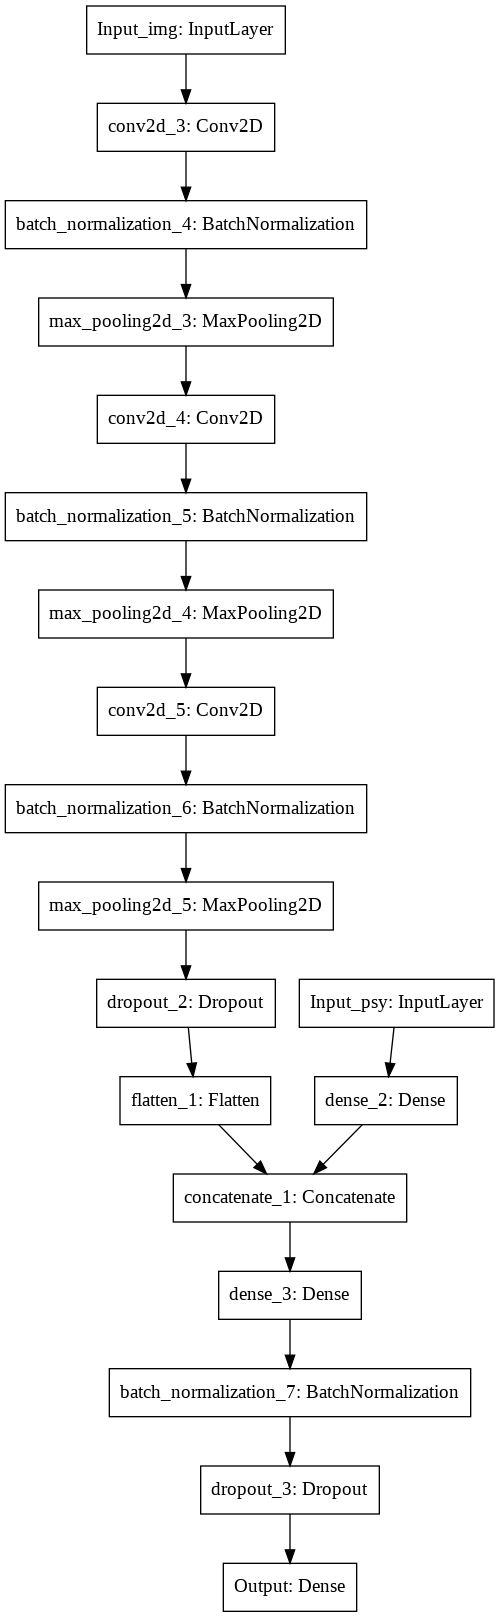

In [ ]:
input_layer_psy = tf.keras.layers.Input(shape=(trainAttrX.shape[1]), name="Input_psy") 
input_layer_img = tf.keras.layers.Input(shape=(100, 100, 3), name="Input_img") 

# -- PSY --
l1 = tf.keras.layers.Dense(500, activation='relu',)(input_layer_psy)
# l1 = tf.keras.layers.Dense(500, activation='relu',)(l1)
# l1 = tf.keras.layers.Dense(1000, activation='relu',)(l1)
# l1 = tf.keras.layers.Dense(2000, activation='relu',)(l1)


# -- IMG -- 
x = tf.keras.layers.Conv2D(filters=3, activation='relu', kernel_size=(3,3))(input_layer_img)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)

x = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=6, activation='relu')(x)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)

x = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=8, activation='relu')(x)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)

# x = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=10, activation='relu')(x)
# x = tf.keras.layers.BatchNormalization(axis=-1)(x)
# x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)

x = tf.keras.layers.Dropout(0.7)(x)

l_f = tf.keras.layers.Flatten()(x)
# -- MERGING -- 
x = tf.keras.layers.concatenate([l1, l_f])

x = tf.keras.layers.Dense(110, activation='relu')(x)
# x = tf.keras.layers.Dense(1000, activation='relu')(x)
x = tf.keras.layers.BatchNormalization(axis=-1)(x)
# x = tf.keras.layers.Dense(1200, activation='relu')(x)
# x = tf.keras.layers.Dense(800, activation='relu')(x)

x = tf.keras.layers.Dropout(0.7)(x)

output = tf.keras.layers.Dense(11, name="Output", activation="softmax")(x)

model = tf.keras.Model([input_layer_psy, input_layer_img], output)

tf.keras.utils.plot_model(model, show_shapes=False)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 98, 98, 3)    84          Input_img[0][0]                  
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 98, 98, 3)    12          conv2d_3[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 49, 49, 3)    0           batch_normalization_4[0][0]      
____________________________________________________________________________________________

In [ ]:
# checkpoint = tf.keras.callbacks.ModelCheckpoint("drive/MyDrive/CRIApp/model.hdf5")
# logger = CSVLogger('drive/MyDrive/CRIApp/model.log')

# model = tf.keras.Model([input_layer_psy, input_layer_img], output)

# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
#               loss='sparse_categorical_crossentropy',
#               metrics=['accuracy'])

# EPOCHS = 2500
# BATCH_SIZE = 9 # 6 - ok

# history = model.fit(
#     x = {"Input_psy": trainAttrX, 
#          "Input_img": trainImagesX},
#     y = trainY,
#     epochs=EPOCHS,
#     validation_data=([testAttrX, testImagesX], 
#                      testY),
#     batch_size=BATCH_SIZE,
#     callbacks=[logger, checkpoint],
#     verbose=2)

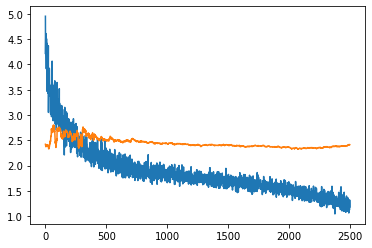

In [ ]:
log = pd.read_csv("model.log")
plt.plot(log['loss'])
plt.plot(log['val_loss'])
plt.show()

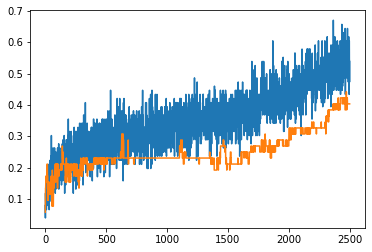

In [ ]:
log = pd.read_csv("model.log")
plt.plot(log['accuracy'])
plt.plot(log['val_accuracy'])
plt.show()

In [ ]:
model = tf.keras.models.load_model('model.hdf5')
model.evaluate([testAttrX, testImagesX], testY)

2/2 [==============================] - 27s 83ms/step - loss: 2.4143 - accuracy: 0.4038


[2.414280891418457, 0.4038461446762085]

In [ ]:
model.optimizer.lr = 0.0006

In [ ]:
# Попытка дообучить нейронку на другом батче 

checkpoint = tf.keras.callbacks.ModelCheckpoint("model_additional.hdf5")
logger = CSVLogger('model_add.log')

EPOCHS = 3000
BATCH_SIZE = 9

history = model.fit(
    x = {"Input_psy": trainAttrX, 
         "Input_img": trainImagesX},
    y = trainY,
    epochs=EPOCHS,
    validation_data=([testAttrX, testImagesX], 
                     testY),
    batch_size=BATCH_SIZE,
    callbacks=[logger, checkpoint],
    initial_epoch=2501,
    verbose=2)

Epoch 2502/3000
9/9 - 1s - loss: 1.2149 - accuracy: 0.5263 - val_loss: 2.4147 - val_accuracy: 0.4038
Epoch 2503/3000
9/9 - 0s - loss: 1.2287 - accuracy: 0.5526 - val_loss: 2.4131 - val_accuracy: 0.4038
Epoch 2504/3000
9/9 - 0s - loss: 1.2618 - accuracy: 0.5789 - val_loss: 2.4139 - val_accuracy: 0.4038
Epoch 2505/3000
9/9 - 0s - loss: 1.1264 - accuracy: 0.6053 - val_loss: 2.4159 - val_accuracy: 0.4038
Epoch 2506/3000
9/9 - 0s - loss: 1.2530 - accuracy: 0.5658 - val_loss: 2.4178 - val_accuracy: 0.4038
Epoch 2507/3000
9/9 - 0s - loss: 1.2790 - accuracy: 0.5658 - val_loss: 2.4173 - val_accuracy: 0.4038
Epoch 2508/3000
9/9 - 0s - loss: 1.4582 - accuracy: 0.4868 - val_loss: 2.4156 - val_accuracy: 0.4038
Epoch 2509/3000
9/9 - 0s - loss: 1.3205 - accuracy: 0.5263 - val_loss: 2.4175 - val_accuracy: 0.4038
Epoch 2510/3000
9/9 - 0s - loss: 1.3174 - accuracy: 0.6053 - val_loss: 2.4188 - val_accuracy: 0.4038
Epoch 2511/3000
9/9 - 0s - loss: 1.1371 - accuracy: 0.5658 - val_loss: 2.4215 - val_accurac

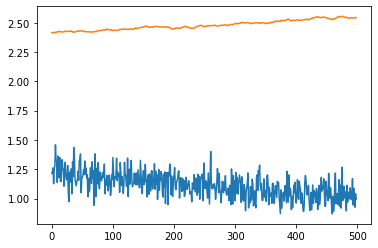

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

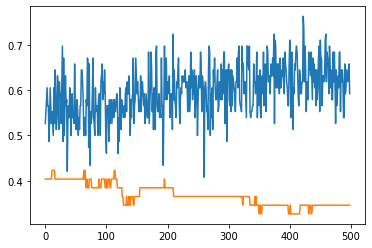

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

#Тест модели

(1, 100, 100, 3)
(1, 101)
Predicted:  8


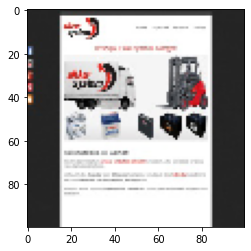

In [ ]:
from tensorflow.keras.preprocessing import image

def preprocessing(img):
  img = image.img_to_array(img, dtype=np.dtype('float32'))[None,...]  / 255.
  img = tfa.image.gaussian_filter2d(img)

  return img

# Загрузить картинку - прогнать через препроцессинг - добавить измерение батча
img = image.load_img("Screenshots_for_NN/6_.jpg", target_size=(100,100))
plt.imshow(img)
img = preprocessing(img)
print(img.shape)

p = np.array(df.iloc[3][:-1], dtype=np.dtype('float32'))[None, ...]
print(p.shape)
 

print(
    "Predicted: ", np.argmax(model.predict([p, img]))
)